<a href="https://colab.research.google.com/github/Tony607/mmdetection_instance_segmentation_demo/blob/master/mmdetection_train_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to create custom COCO data set for instance segmentation](https://www.dlology.com/blog/how-to-create-custom-coco-data-set-for-instance-segmentation/) | DLology blog

## Install Open MMLab Detection Toolbox

In [3]:
import os
from os.path import exists, join, basename, splitext

# TODO: change URL to your fork of my repository if necessary.
git_repo_url = 'https://github.com/Tony607/mmdetection_instance_segmentation_demo'

%cd /content
project_name = os.path.abspath(splitext(basename(git_repo_url))[0])
mmdetection_dir = os.path.join(project_name, "mmdetection")
if not exists(project_name):
    # clone "depth 1" will only get the latest copy of the relevant files.
    !git clone -q --recurse-submodules --depth 1 $git_repo_url
    print("Update mmdetection repo")
    !cd {mmdetection_dir} && git checkout master && git pull
    # dependencies
    !pip install -q mmcv terminaltables
    # build
    !cd {mmdetection_dir} && python setup.py install
    !pip install -r {os.path.join(mmdetection_dir, "requirements.txt")}

/content


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect.
import os
from os.path import exists, join, basename, splitext

# TODO: change URL to your fork of my repository if necessary.
git_repo_url = 'https://github.com/Tony607/mmdetection_instance_segmentation_demo'

%cd /content
project_name = os.path.abspath(splitext(basename(git_repo_url))[0])
mmdetection_dir = os.path.join(project_name, "mmdetection")

## Your settings

In [0]:
import os
import sys
sys.path.append(mmdetection_dir)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

# You can add more model configs like below.
MODELS_CONFIG = {
    'mask_rcnn_r50_fpn_1x': {
        'config_file': 'configs/mask_rcnn_r50_fpn_1x.py'
    },
    'cascade_mask_rcnn_r50_fpn_1x': {
        'config_file': 'configs/cascade_mask_rcnn_r50_fpn_1x.py',
    }
}

In [0]:
# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'mask_rcnn_r50_fpn_1x'  # 'cascade_mask_rcnn_r50_fpn_1x'

# Total training epochs.
total_epochs = 20

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

## Modify config file

In [4]:
import os
config_fname = os.path.join(project_name, 'mmdetection', config_file)

assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'/content/mmdetection_instance_segmentation_demo/mmdetection/configs/mask_rcnn_r50_fpn_1x.py'

In [5]:
import json
annotation_path = os.path.join(project_name, "data", "trainval.json")
json_file = open(annotation_path)
coco = json.load(json_file)
print(coco["categories"])
classes_names = [category["name"] for category in coco["categories"]]
print(classes_names)

[{'supercategory': 'date', 'id': 1, 'name': 'date'}, {'supercategory': 'fig', 'id': 2, 'name': 'fig'}, {'supercategory': 'hazelnut', 'id': 3, 'name': 'hazelnut'}]
['date', 'fig', 'hazelnut']


In [6]:
import re
fname = config_fname
with open(fname) as f:
    s = f.read()
    work_dir = re.findall(r"work_dir = \'(.*?)\'", s)[0]
    # Update `num_classes` including `background` class.
    s = re.sub('num_classes=.*?,',
               'num_classes={},'.format(len(classes_names) + 1), s)
    s = re.sub('total_epochs = \d+',
               'total_epochs = {} #'.format(total_epochs), s)
    if "CocoDataset" in s:
        s = re.sub("data_root = 'data/coco/'",
                   "data_root = 'data/'", s)
        s = re.sub("annotations/instances_train2017.json",
                   "trainval.json", s)
        s = re.sub("annotations/instances_val2017.json",
                   "trainval.json", s)
        s = re.sub("annotations/instances_val2017.json",
                   "trainval.json", s)
        s = re.sub("train2017", "images", s)
        s = re.sub("val2017", "images", s)
    else:
        s = re.sub('img_prefix=.*?\],',
                   "img_prefix=data_root + 'images',".format(total_epochs), s)
with open(fname, 'w') as f:
    f.write(s)
!cat {config_fname}

# model settings
model = dict(
    type='MaskRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_scales=[8],
        anchor_ratios=[0.5, 1.0, 2.0],
        anchor_strides=[4, 8, 16, 32, 64],
        target_means=[.0, .0, .0, .0],
        target_stds=[1.0, 1.0, 1.0, 1.0],
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='SmoothL1Loss', beta=1.0 / 9.0, loss_weight=1.0)),
    bbox_roi_extractor=dict(
        type='SingleRoIExtractor',
        roi_layer=dict(type='RoIAlign', out_size=7, sample_num=2),
        out_channels=25

## Train the model

In [7]:
%cd {project_name}
!python mmdetection/tools/train.py {config_fname}

/content/mmdetection_instance_segmentation_demo
2019-10-13 12:32:52,895 - INFO - Distributed training: False
2019-10-13 12:32:53,454 - INFO - load model from: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100% 97.8M/97.8M [00:00<00:00, 111MB/s]
2019-10-13 12:32:55,081 - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2019-10-13 12:33:01,259 - INFO - Start running, host: root@b49ef13b84e1, work_dir: /content/mmdetection_instance_segmentation_demo/work_dirs/mask_rcnn_r50_fpn_1x
2019-10-13 12:33:01,260 - INFO - workflow: [('train', 1)], max: 20 epochs


### Verify the checkpoint file exists.

In [8]:
%cd {project_name}
checkpoint_file = os.path.join(work_dir, "latest.pth")
assert os.path.isfile(
    checkpoint_file), '`{}` not exist'.format(checkpoint_file)
checkpoint_file = os.path.abspath(checkpoint_file)
checkpoint_file

/content/mmdetection_instance_segmentation_demo


'/content/mmdetection_instance_segmentation_demo/work_dirs/mask_rcnn_r50_fpn_1x/latest.pth'

## Test predict

Turn down the `score_thr` if you think the model is missing any bbox.
Turn up the `score_thr` if you see too much overlapping bboxes with low scores.

In [0]:
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import mmcv
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
# fix for colab


def imshow(img, win_name='', wait_time=0): plt.figure(
    figsize=(50, 50)); plt.imshow(img)


mmcv_image.imshow = imshow
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result, init_detector

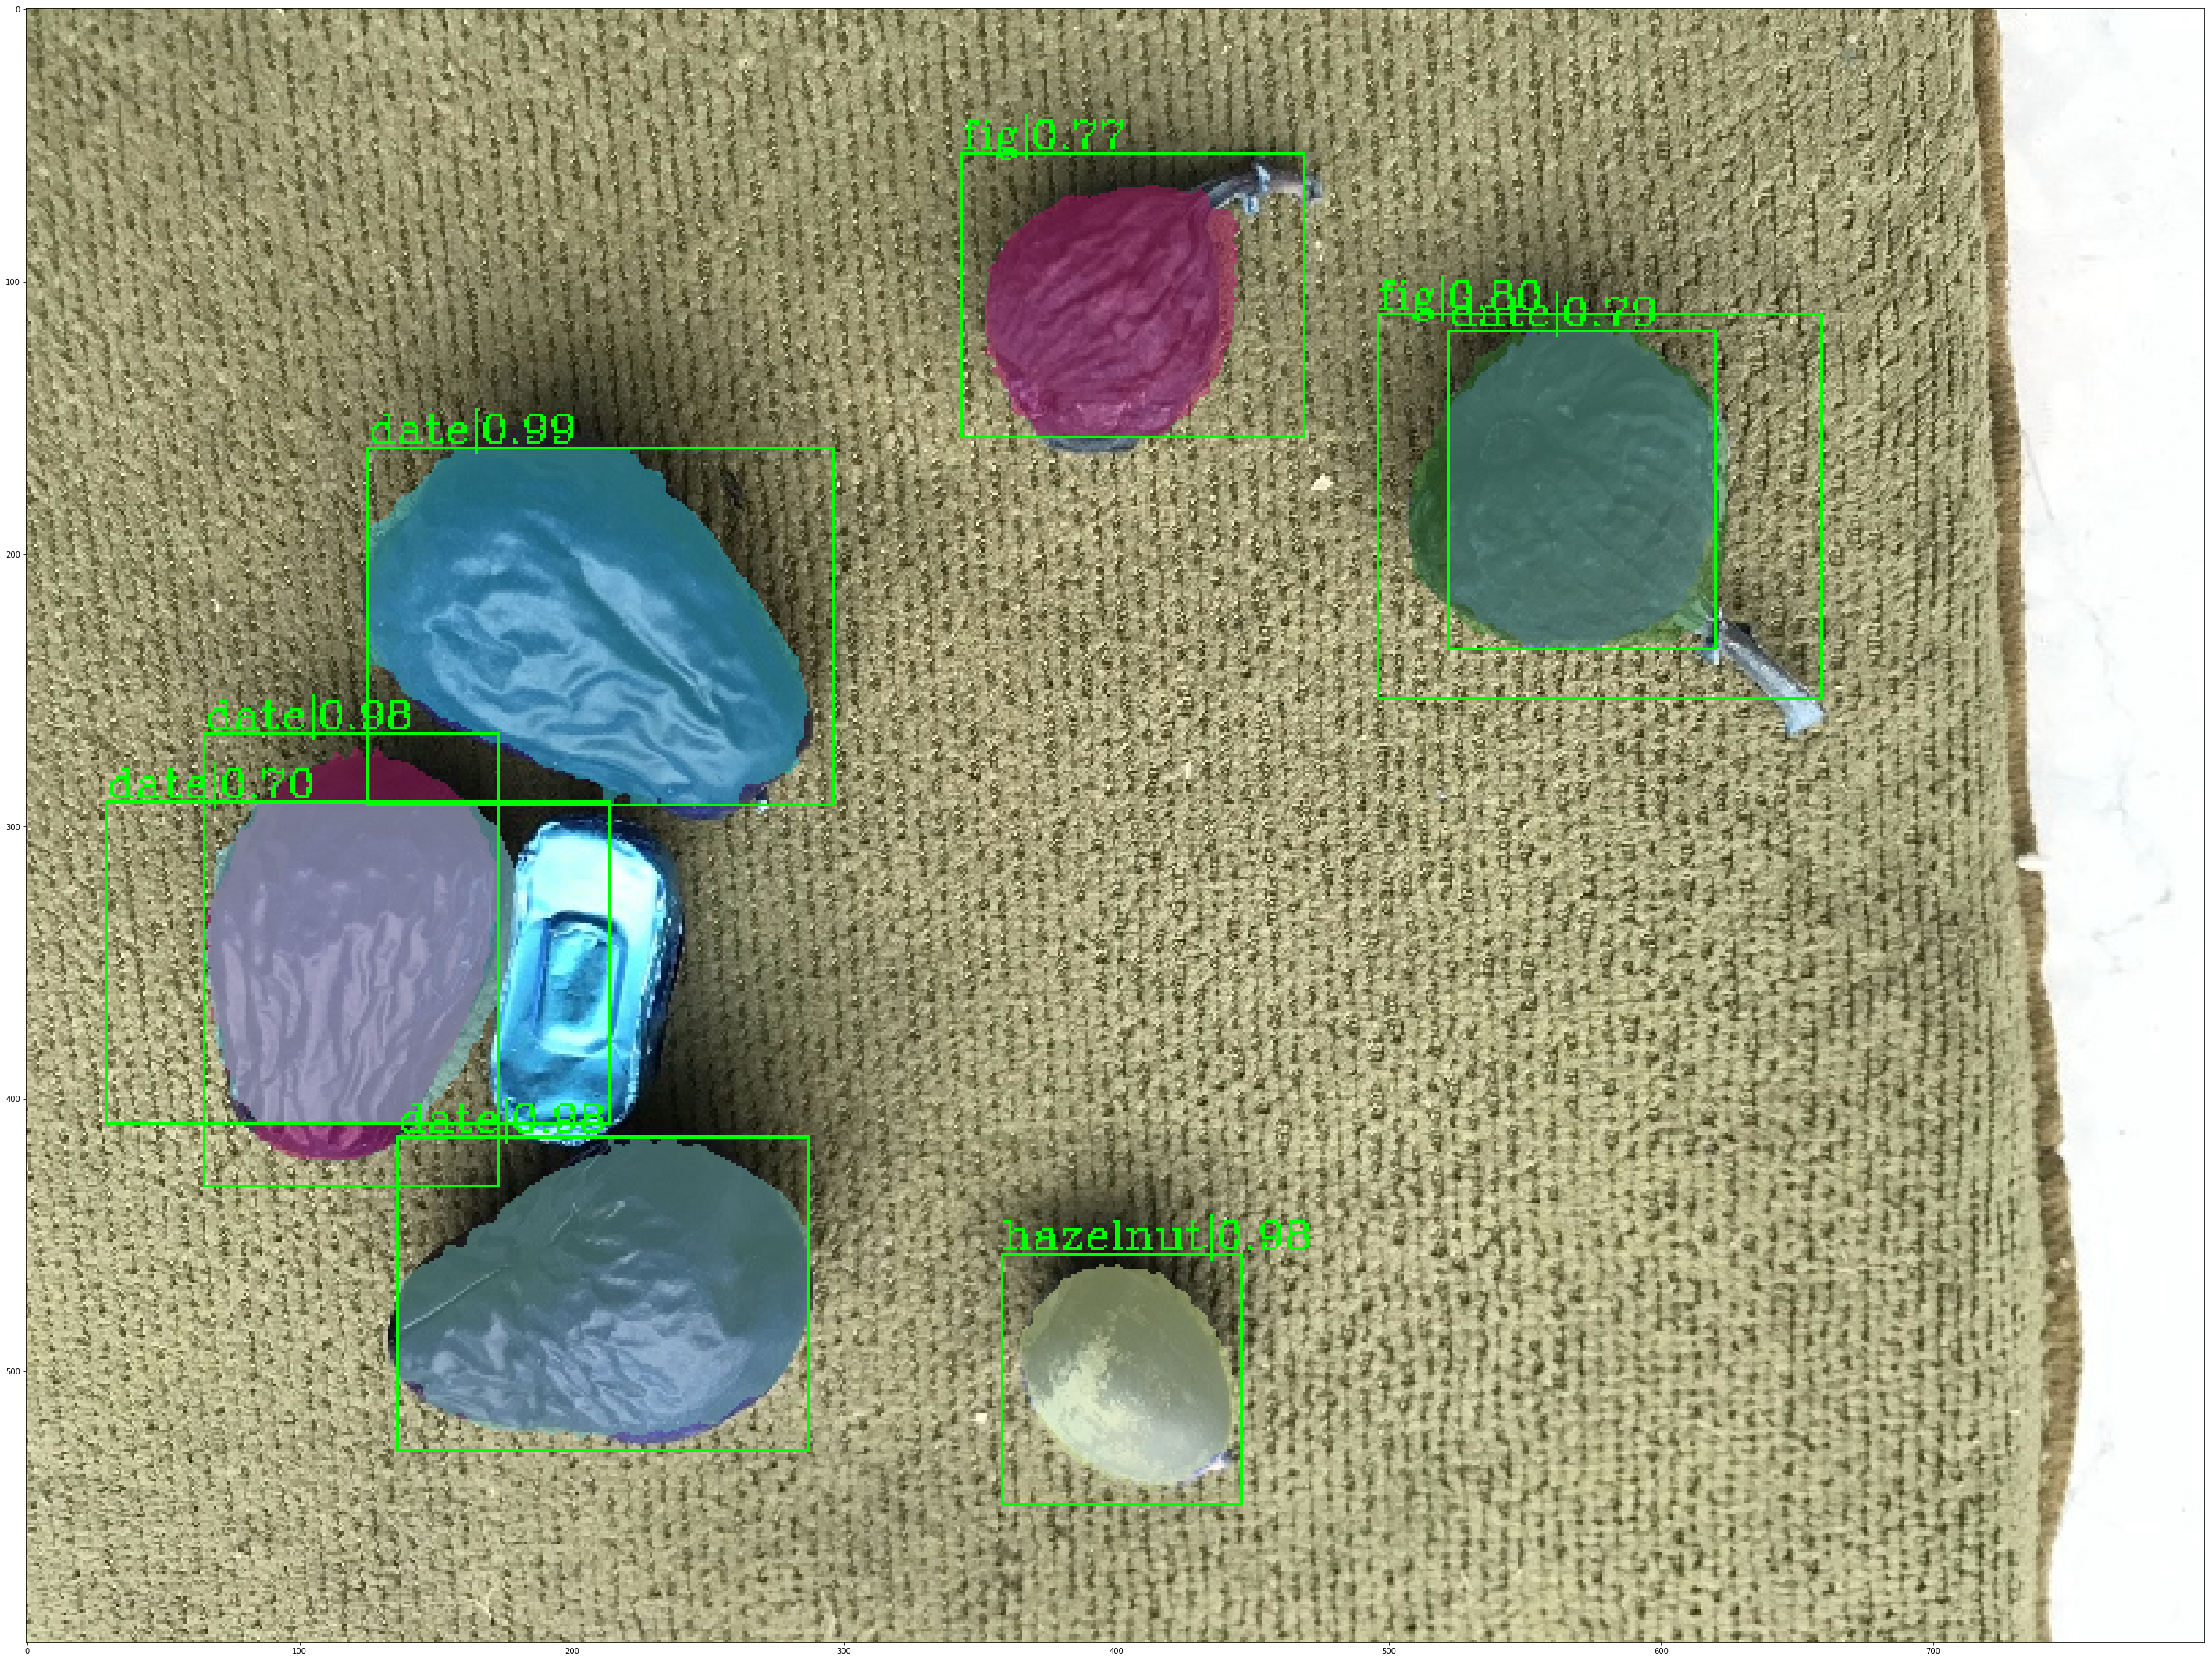

In [10]:
score_thr = 0.5

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)

# test a single image and show the results
img = 'data/images/15.jpg'

result = inference_detector(model, img)
show_result(img, result, classes_names,
            score_thr=score_thr, out_file="result.jpg")

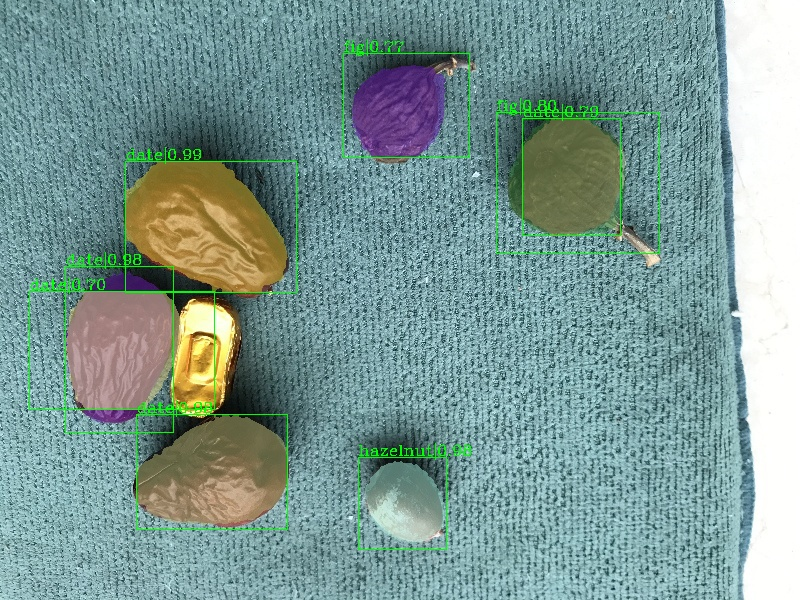

In [11]:
from IPython.display import Image
Image(filename='result.jpg')

## Benchmark inference speed

In [14]:
import time
import numpy as np

times = []
for i in range(20):
    start_time = time.time()
    result = inference_detector(model, img)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.41,fps:2.45


## Download the config file

In [0]:
from google.colab import files

files.download(config_fname)

## Download checkpoint file.

### Option1 : upload the checkpoint file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp {checkpoint_file} /content/drive

### Option2 :  Download the checkpoint file directly to your local file system
This method may not be stable when downloading large files like the model checkpoint file. Try **option 1** instead if not working.

In [0]:
from google.colab import files
files.download(checkpoint_file)